# IMDB dataset

### Preprocess

In [2]:
import pandas as pd


def clean_text(df: pd.DataFrame) -> pd.DataFrame:
    sentences = df.sentence.values

    cleaned_sentences = []
    for sentence in sentences:
        sentence = sentence.replace('<br /><br />', ' ')
        cleaned_sentences.append(sentence)

    df['sentence'] = cleaned_sentences
    return df

In [7]:
# from src import DATA_DIR
#
# DATA_DIR = DATA_DIR.joinpath('imdb')
#
# df_train = pd.read_csv(DATA_DIR.joinpath('train.tsv'), sep='\t')
# df_train_cleaned = clean_text(df_train)
# df_train_cleaned.to_csv(DATA_DIR.joinpath('train.tsv'), sep='\t', index=False)
#
# df_dev = pd.read_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t')
# df_dev_cleaned = clean_text(df_dev)
# df_dev_cleaned.to_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t', index=False)
#
# df_test = pd.read_csv(DATA_DIR.joinpath('test.tsv'), sep='\t')
# df_test_cleaned = clean_text(df_test)
# df_test_cleaned.to_csv(DATA_DIR.joinpath('test.tsv'), sep='\t', index=False)

## Read data

In [3]:
from src.settings import DATA_DIR

DATA_DIR = DATA_DIR.joinpath('imdb')

df_train = pd.read_csv(DATA_DIR.joinpath('train.tsv'), sep='\t')
df_dev = pd.read_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t')
df_test = pd.read_csv(DATA_DIR.joinpath('test.tsv'), sep='\t')

In [4]:
df_train.head()

,sentence,label
0,I have nothing against religious movies. Relig...,0
1,Unfortunately for myself - I stumbled onto thi...,1
2,A man brings his new wife to his home where hi...,0
3,I'm not sure that this comment contains an act...,1
4,when i first started watching these it became ...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  22500 non-null  object
 1   label     22500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 351.7+ KB


In [6]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2500 non-null   object
 1   label     2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  25000 non-null  object
 1   label     25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


### Concat all splits

In [17]:
df_train['split'] = 'train'
df_dev['split'] = 'val'
df_test['split'] = 'test'
df_all = pd.concat([df_train, df_dev, df_test], ignore_index=True)

### Label distribution

Unique labels: [0 1]


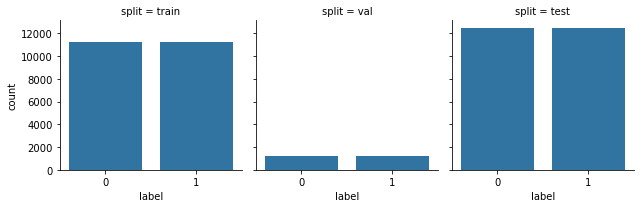

In [18]:
import seaborn as sns

print(f'Unique labels: {df_all.label.unique()}')

g = sns.FacetGrid(df_all, col="split")
g.map(sns.countplot, 'label', order=[0, 1])

### Text length

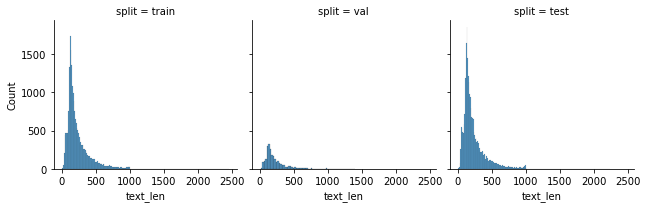

In [19]:
df_all['text_len'] = df_all.sentence.apply(lambda x: len(x.split(' ')))

g = sns.FacetGrid(df_all, col="split")
g.map(sns.histplot, 'text_len')

In [20]:
df_all.describe()

,label,text_len
count,50000.000000,50000.000000
mean,0.500000,229.128580
std,0.500005,169.788943
min,0.000000,4.000000
25%,0.000000,125.000000
50%,0.500000,172.000000
75%,1.000000,278.000000
max,1.000000,2460.000000


### Tokenized text length

In [21]:
from transformers import AutoTokenizer

HUGGINGFACE_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(HUGGINGFACE_MODEL_NAME, do_lower_case=True)

texts = df_all['sentence'].values.tolist()

text_tokenized = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    truncation=False,
    padding=False,
    return_length=True
)
text_tokens = text_tokenized['input_ids']
lengths = text_tokenized['length']

df_all['tok_len'] = lengths
df_all.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


,sentence,label,split,text_len,tok_len
0,I have nothing against religious movies. Relig...,0,train,183,234
1,Unfortunately for myself - I stumbled onto thi...,1,train,136,197
2,A man brings his new wife to his home where hi...,0,train,242,307
3,I'm not sure that this comment contains an act...,1,train,199,284
4,when i first started watching these it became ...,1,train,391,521


In [22]:
df_all.describe()

,label,text_len,tok_len
count,50000.000000,50000.000000,50000.000000
mean,0.500000,229.128580,310.427340
std,0.500005,169.788943,232.013278
min,0.000000,4.000000,10.000000
25%,0.000000,125.000000,168.000000
50%,0.500000,172.000000,232.000000
75%,1.000000,278.000000,376.000000
max,1.000000,2460.000000,3339.000000


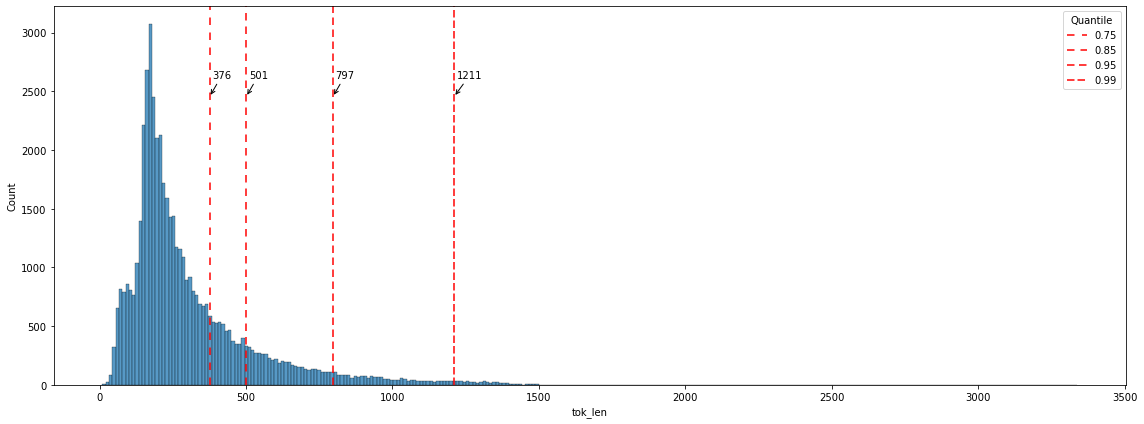

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))

sns.histplot(x='tok_len', data=df_all, ax=ax)
max_val = max([p.get_height() for p in ax.patches])
for q, ls in zip([0.75, 0.85, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)), (0, (5, 3)), (0, (5, 2))]):
    qv = int(df_all['tok_len'].quantile(q))
    ax.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
    ax.annotate(
        qv,
        xy=(qv, max_val * 0.8),
        xytext=(qv + 9, max_val * 0.85),
        arrowprops=dict(arrowstyle="->", color='black'),
    )

ax.legend(title='Quantile')

fig.tight_layout()